In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
sns.set(rc = {'figure.figsize':(10, 6)})
pd.set_option("precision", 3)

In [2]:
folder = "/home/jarobyte/scratch/guemes/icdar/bg/baseline/experiments/"

In [3]:
files = os.listdir(folder)
len(files)

13

In [4]:
logs = pd.concat([pd.read_csv(folder + f) 
                       for f in tqdm(os.listdir(folder))])\
.assign(dropout = lambda df: df.dropout.round(2))
print(logs.shape)
logs.head()

  0%|          | 0/13 [00:00<?, ?it/s]

(514, 21)


,epoch,train_loss,train_error_rate,dev_loss,dev_error_rate,training_minutes,learning_rate,weight_decay,model,max_sequence_length,...,feedforward_dimension,encoder_layers,decoder_layers,attention_heads,activation,dropout,parameters,encoder_tokens,decoder_tokens,experiment_id
0,1,4.759,86.784,4.323,83.297,0.013,1.000e-04,0.01,Transformer,110,...,512,4,4,8,relu,0.1,1939519,191,191,test
1,2,4.200,82.535,4.148,83.297,0.027,1.000e-04,0.01,Transformer,110,...,512,4,4,8,relu,0.1,1939519,191,191,test
2,3,4.029,82.485,4.043,83.297,0.038,1.000e-04,0.01,Transformer,110,...,512,4,4,8,relu,0.1,1939519,191,191,test
3,4,3.914,82.480,3.962,83.297,0.050,1.000e-04,0.01,Transformer,110,...,512,4,4,8,relu,0.1,1939519,191,191,test
4,5,3.822,82.475,3.898,83.297,0.061,1.000e-04,0.01,Transformer,110,...,512,4,4,8,relu,0.1,1939519,191,191,test


In [5]:
experiments = logs\
.assign(fit = lambda df: df.apply(lambda r: {k:r[k] for k in ["train_loss", 
                                                              "dev_loss", 
                                                              "epoch"]}, 
                                  axis = 1))\
.groupby("experiment_id")\
.agg({"fit":(lambda x: min(x, key = lambda y: y["dev_loss"])),
      "parameters":max, 
      "dropout":max,
      "weight_decay":max,
      "embedding_dimension":max,
      "encoder_layers":max,
      "training_minutes":max})\
.assign(parameters = lambda df: df.parameters / 10**6, 
        train_loss = lambda df: df.fit.map(lambda x: x["train_loss"]),
        dev_loss = lambda df: df.fit.map(lambda x: x["dev_loss"]),
        epoch = lambda df: df.fit.map(lambda x: x["epoch"]))\
.drop(columns = "fit")
experiments.head(10)

,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
experiment_id,,,,,,,,,
22694244_1,1.94,0.1,1.000e-02,128,4,131.975,2.450,2.521,42
22694244_10,1.94,0.2,1.000e-03,128,4,132.872,0.389,0.326,41
22694244_11,1.94,0.4,1.000e-03,128,4,128.876,0.816,0.709,36
22694244_12,1.94,0.3,1.000e-03,128,4,130.874,0.426,0.345,38
22694244_2,1.94,0.2,1.000e-04,128,4,131.184,0.251,0.278,19
22694244_3,1.94,0.5,1.000e-02,128,4,129.310,2.484,2.558,42
22694244_4,1.94,0.4,1.000e-03,128,4,131.540,0.496,0.381,42
22694244_5,1.94,0.1,1.000e-03,128,4,129.585,0.312,0.323,42
22694244_6,1.94,0.5,1.000e-02,128,4,127.898,2.467,2.527,42


# evaluation

In [6]:
evaluation_folder = "/home/jarobyte/scratch/guemes/icdar/bg/baseline/evaluation/"

In [7]:
evaluation_files = os.listdir(evaluation_folder)
len(evaluation_files)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


13

In [8]:
evaluation = pd.concat([pd.read_csv(evaluation_folder + f) 
                       for f in tqdm(os.listdir(evaluation_folder))])
print(evaluation.shape)
evaluation.head()

  0%|          | 0/13 [00:00<?, ?it/s]

(130, 9)


,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting
0,22694244_7,-748.841,disjoint,greedy,100,4.960,9.394,79.741,NaN
1,22694244_7,-710.747,disjoint,greedy,50,2.434,9.394,76.162,NaN
2,22694244_7,-752.208,disjoint,beam,100,11.484,9.394,80.057,NaN
3,22694244_7,-704.086,disjoint,beam,50,10.810,9.394,75.536,NaN
4,22694244_7,-740.690,sliding,greedy,50,44.134,9.394,78.975,uniform


In [9]:
evaluation.improvement.describe()

count    130.000
mean    -428.530
std      375.876
min     -964.557
25%     -748.286
50%     -708.695
75%      -12.628
max       34.304
Name: improvement, dtype: float64

In [10]:
results = evaluation.merge(experiments, right_index = True, left_on = "experiment_id")\
.sort_values("improvement", ascending = False)
results.head(20)

,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
5,22694244_2,34.304,sliding,greedy,50,41.748,9.394,6.172,triangle,1.94,0.2,1.000e-04,128,4,131.184,0.251,0.278,19
6,22694244_2,34.260,sliding,greedy,50,42.082,9.394,6.176,bell,1.94,0.2,1.000e-04,128,4,131.184,0.251,0.278,19
4,22694244_2,33.893,sliding,greedy,50,41.760,9.394,6.210,uniform,1.94,0.2,1.000e-04,128,4,131.184,0.251,0.278,19
0,22694244_2,33.686,disjoint,greedy,100,4.705,9.394,6.230,NaN,1.94,0.2,1.000e-04,128,4,131.184,0.251,0.278,19
0,22694244_9,30.038,disjoint,greedy,100,3.977,9.394,6.572,NaN,1.94,0.1,1.000e-04,128,4,127.286,0.242,0.264,12
4,22694244_10,25.757,sliding,greedy,50,35.962,9.394,6.974,uniform,1.94,0.2,1.000e-03,128,4,132.872,0.389,0.326,41
6,22694244_10,25.506,sliding,greedy,50,35.916,9.394,6.998,bell,1.94,0.2,1.000e-03,128,4,132.872,0.389,0.326,41
7,22694244_10,25.344,sliding,beam,50,341.166,9.394,7.013,uniform,1.94,0.2,1.000e-03,128,4,132.872,0.389,0.326,41
5,22694244_10,25.299,sliding,greedy,50,35.754,9.394,7.017,triangle,1.94,0.2,1.000e-03,128,4,132.872,0.389,0.326,41
9,22694244_10,23.221,sliding,beam,50,337.482,9.394,7.213,bell,1.94,0.2,1.000e-03,128,4,132.872,0.389,0.326,41


<AxesSubplot:>

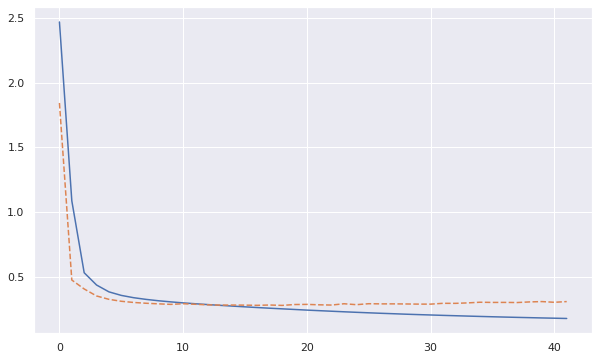

In [11]:
logs.query("experiment_id == '22694244_2'").train_loss.plot()
logs.query("experiment_id == '22694244_2'").dev_loss.plot(ls = "--")

In [12]:
results.query("experiment_id == '22694244_2'")\
[["experiment_id", "window", "window_size", "decoding", "weighting", "improvement"]]\
.sort_values(["window", "window_size", "decoding", "weighting"])\
.pivot(index = "experiment_id", 
       values = "improvement", 
       columns = ["window", "window_size", "decoding", "weighting"])

window        disjoint                       sliding                          \
window_size        50            100             50                            
decoding          beam greedy   beam  greedy    beam                  greedy   
weighting          NaN    NaN    NaN     NaN    bell triangle uniform   bell   
experiment_id                                                                  
22694244_2    -145.167 -6.867  2.755  33.686 -26.962  -25.425 -19.005  34.26   

window                          
window_size                     
decoding                        
weighting     triangle uniform  
experiment_id                   
22694244_2      34.304  33.893